In [ ]:
import json
import os
import re
import textwrap

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
# Define a function to pretty-print JSON with wrapped lines
def pretty_print_json(data, max_width=80):
    json_str = json.dumps(data, indent=4)
    wrapped_lines = []
    for line in json_str.splitlines():
        wrapped_lines.extend(textwrap.wrap(line, width=max_width))
    return "\n".join(wrapped_lines)

file_path = os.path.join("eval_baseline_emrqa", "eval_predictions.jsonl")
with open(file_path, "r") as file:
    predictions = [json.loads(line) for line in file]

# Filter failed examples where the predicted answer does not match the expected answer
failed_examples = [
    prediction for prediction in predictions
    if prediction['predicted_answer'] != prediction['answers']['text'][0] # for whatever reason this is a list
]

# Put Failed examples in a dataframe
failed = pd.DataFrame(failed_examples)
failed['answer'] = [v['text'][0] for v in failed["answers"].values]
# pd.set_option('display.max_colwidth', 20)
failed.columns
len(failed)

In [15]:
# -----------------------------
# 1. Basic helpers
# -----------------------------

STOPWORDS = {
    "the","a","an","and","or","but","if","then","so","for","of","on","in","to",
    "with","without","by","at","from","as","is","are","was","were","be","been",
    "being","that","this","these","those","it","its","into","about","than",
    "such","which","who","whom","whose","what","when","where","why","how"
}

def tokenize(text):
    return re.findall(r"\w+|\d+|\S", text.lower())

def content_tokens(text):
    toks = tokenize(text)
    return [t for t in toks if t.isalpha() and t not in STOPWORDS]

def jaccard_overlap(a, b):
    A = set(content_tokens(a))
    B = set(content_tokens(b))
    if not A or not B:
        return 0.0
    return len(A & B) / len(A | B)

def has_number(text):
    return bool(re.search(r"\d", text))

def count_numbers(text):
    return len(re.findall(r"\d+(?:\.\d+)?", text))

MONTH_PAT = r"(jan|feb|mar|apr|may|jun|jul|aug|sep|sept|oct|nov|dec)"
DATE_PAT = rf"(\d{{1,2}}/\d{{1,2}}/\d{{2,4}}|\d{{4}}-\d{{1,2}}-\d{{1,2}}|{MONTH_PAT})"

def count_dates(text):
    return len(re.findall(DATE_PAT, text.lower()))

def shannon_entropy(tokens):
    if not tokens:
        return 0.0
    counts = Counter(tokens)
    total = sum(counts.values())
    probs = [c/total for c in counts.values()]
    return -sum(p*np.log(p + 1e-12) for p in probs)

def stopword_ratio(text):
    toks = tokenize(text)
    if not toks:
        return 0.0
    sw = sum(1 for t in toks if t in STOPWORDS)
    return sw / len(toks)

def classify_question_type(q):
    q_low = q.lower()
    if any(x in q_low for x in ["when", "date", "time", "year", "day", "month"]):
        return "time"
    if any(x in q_low for x in ["how many", "how much", "number", "count", "dose", "dosage", "mg", "mcg"]):
        return "number"
    return "other"

# -----------------------------
# 2. Global stats for thresholds (lengths)
# -----------------------------
# Compute gold answer lengths for failed examples
gold_lengths = failed['answer'].fillna("").apply(lambda x: len(tokenize(x)))

# 95th percentile of gold answer lengths (for anomaly thresholding)
length_p95 = np.percentile(gold_lengths, 95) if len(gold_lengths) > 0 else 100

# Median gold answer length (typical answer size)
length_med = np.median(gold_lengths) if len(gold_lengths) > 0 else 0

# Median absolute deviation (robust spread/variability)
mad = np.median(np.abs(gold_lengths - length_med)) if len(gold_lengths) > 0 else 0

# Tune this as needed
LENGTH_THRESHOLD = max(length_p95, length_med + 2 * mad)

# -----------------------------
# 3. Rule implementations (per-row)
# -----------------------------

def rule1_length_anomaly(answer_text):
    """Gold span length is abnormally large."""
    return len(tokenize(answer_text)) > LENGTH_THRESHOLD

def rule2_multi_clause(answer_text):
    """Gold span looks like multiple clauses/list items."""
    clauses = re.split(r',|\n|;|\band\b|\bor\b', answer_text, flags=re.IGNORECASE)
    informative = [c for c in clauses if len(content_tokens(c)) >= 3]
    return len(informative) > 1

def rule3_low_question_similarity(answer_text, question, sim_threshold=0.05):
    """Gold span has very low lexical overlap with question."""
    overlap = jaccard_overlap(answer_text, question)
    return overlap < sim_threshold

def rule4_pred_inside_gold_better_alignment(pred, gold, question, margin=0.1):
    """
    Predicted span is inside gold span AND aligns better with the question.
    Strong hint gold is a noisy chunk. This is a very important one.
    """
    gold_clean = gold or ""
    pred_clean = pred or ""
    if not pred_clean or pred_clean.strip() not in gold_clean:
        return False
    q_gold = jaccard_overlap(gold_clean, question)
    q_pred = jaccard_overlap(pred_clean, question)
    return q_pred > q_gold + margin

def rule5_question_type_mismatch(answer_text, question):
    """
    Question type vs answer structure mismatch:
    - time question but zero or multiple date-like expressions
    - number question but zero or many numeric expressions
    """
    qtype = classify_question_type(question)
    if qtype == "time":
        n_dates = count_dates(answer_text)
        return n_dates == 0 or n_dates > 1
    if qtype == "number":
        n_nums = count_numbers(answer_text)
        return n_nums == 0 or n_nums > 3  # >3 is "probably a list"
    return False

def rule6_multiple_occurrences_in_context(answer_text, context):
    """Gold span appears multiple times in the context: ambiguous / alignment suspect."""
    if not answer_text:
        return False
    return context.count(answer_text) > 1

def rule7_boundary_weirdness(answer_text):
    """Gold span starts/ends with separators or looks cut mid-clause."""
    txt = answer_text.strip()
    if not txt:
        return False
    if txt.startswith((",", ";", "and", "or")):
        return True
    if txt.endswith((",", ";", "and", "or")):
        return True
    # starts/ends with odd characters
    if txt[0] in "/-:" or txt[-1] in "/-:":
        return True
    return False

def rule8_pred_answers_question_better(pred, gold, question, margin=0.1):
    """Pred span has much better question alignment than gold (even if not substring)."""
    q_gold = jaccard_overlap(gold or "", question)
    q_pred = jaccard_overlap(pred or "", question)
    return q_pred > q_gold + margin

# -----------------------------
# 4. Apply rules to `failed` dataframe
# -----------------------------

def compute_dataset_error_flags(row):
    ctx = row.get("context", "") or ""
    q   = row.get("question", "") or ""
    gold = row.get("answer", "") or ""
    pred = row.get("predicted_answer", "") or ""

    r1 = rule1_length_anomaly(gold)
    r2 = rule2_multi_clause(gold)
    r3 = rule3_low_question_similarity(gold, q)
    r4 = rule4_pred_inside_gold_better_alignment(pred, gold, q)
    r5 = rule5_question_type_mismatch(gold, q)
    r6 = rule6_multiple_occurrences_in_context(gold, ctx)
    r7 = rule7_boundary_weirdness(gold)
    r10 = rule8_pred_answers_question_better(pred, gold, q)

    flags = {
        "rule1_length_anomaly": r1,
        "rule2_multi_clause": r2,
        "rule3_low_q_similarity": r3,
        "rule4_pred_inside_gold_better": r4,
        "rule5_qtype_mismatch": r5,
        "rule6_multi_occurrences": r6,
        "rule7_boundary_weirdness": r7,
        "rule8_pred_better_q_alignment": r10,
    }
    # simple score: how many rules think "dataset error"
    flags["dataset_error_score"] = sum(flags.values())
    # threshold: at least 2 rules triggered -> call it dataset error (tune this)
    flags["is_dataset_error"] = flags["dataset_error_score"] >= 2
    return pd.Series(flags)

# Apply to all failed examples
error_flags = failed.apply(compute_dataset_error_flags, axis=1)
failed_with_flags = pd.concat([failed, error_flags], axis=1)


In [16]:
# -----------------------------
# 5. Quick sanity checks / summaries
# -----------------------------

print("Total failed examples:", len(failed_with_flags))
print("Flagged as dataset errors:", failed_with_flags["is_dataset_error"].sum())

print("\nRule trigger rates:")
print(failed_with_flags[
    [c for c in failed_with_flags.columns if c.startswith("rule")]
].sum().sort_values(ascending=False))

Total failed examples: 3248
Flagged as dataset errors: 2173

Rule trigger rates:
rule2_multi_clause               2416
rule7_boundary_weirdness         2322
rule3_low_q_similarity            344
rule5_qtype_mismatch              332
rule1_length_anomaly              146
rule8_pred_better_q_alignment     110
rule6_multi_occurrences            96
rule4_pred_inside_gold_better      47
dtype: int64


In [19]:
# Identify rule columns
rule_cols = [c for c in failed_with_flags.columns if c.startswith("rule")]

# Compute summary
summary = pd.DataFrame({
    "count": failed_with_flags[rule_cols].sum(),
    "percent": failed_with_flags[rule_cols].mean() * 100
}).sort_values("count", ascending=False)
summary

,count,percent
rule2_multi_clause,2416,74.384236
rule7_boundary_weirdness,2322,71.490148
rule3_low_q_similarity,344,10.591133
rule5_qtype_mismatch,332,10.221675
rule1_length_anomaly,146,4.495074
rule8_pred_better_q_alignment,110,3.386700
rule6_multi_occurrences,96,2.955665
rule4_pred_inside_gold_better,47,1.447044


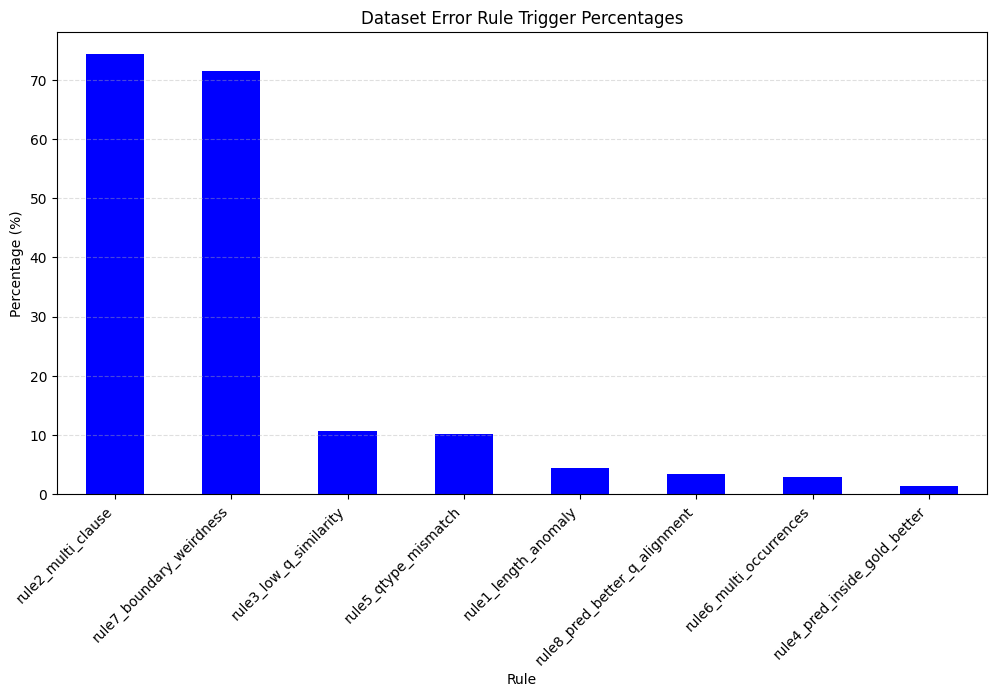

In [22]:
plt.figure(figsize=(12, 6))
summary["percent"].plot(kind="bar", color="blue")
plt.title("Dataset Error Rule Trigger Percentages")
plt.ylabel("Percentage (%)")
plt.xlabel("Rule")
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

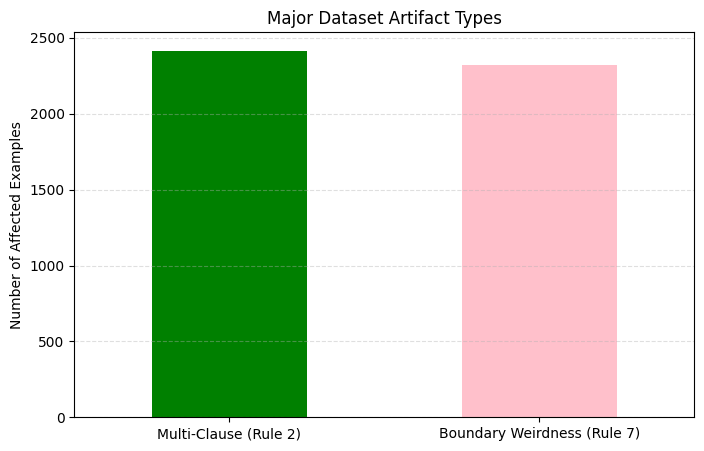

In [24]:
r2 = failed_with_flags[failed_with_flags["rule2_multi_clause"]]
r7 = failed_with_flags[failed_with_flags["rule7_boundary_weirdness"]]
counts = pd.Series({
    "Multi-Clause (Rule 2)": r2.shape[0],
    "Boundary Weirdness (Rule 7)": r7.shape[0]
})

plt.figure(figsize=(8,5))
counts.plot(kind="bar", color=["green", "pink"])
plt.title("Major Dataset Artifact Types")
plt.ylabel("Number of Affected Examples")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.4, linestyle="--")
plt.show()

In [4]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
# failed[failed['question'].str.lower().str.startswith('has')].head(50)
gemfibrozil_examples = failed[failed['question'].str.lower().str.contains('gemfibrozil')]
gemfibrozil_examples.head(5)

10

In [ ]:
len(failed[failed['predicted_answer'] == ',']), len(failed[failed['predicted_answer'] == '.'])

###  Baseline EMRQA prediction error analysis
- High-level error patterns for `eval_baseline_emrqa/eval_predictions.jsonl`
- Label wrong predictions as `truncated_span`, `overlong_span`, `partial_overlap`, or `no_overlap` and show counts/examples.

In [ ]:
# Helpers
token_re = re.compile(r"\w+")
relation = ["truncated_span", "overrun_span", "partial_overlap", "no_overlap"]

def norm(text):
    return " ".join(text.lower().split())

def tokens(text: str):
    return token_re.findall(text.lower())

def span_relation(prediction: str, actual: str):
    p = norm(prediction)
    a = norm(actual)
    if p and p in a:
        return relation[0]
    if a and a in p:
        return relation[1]
    if set(tokens(p)) & set(tokens(a)):
        return relation[2]
    return relation[3]

# Add a new column to the failed dataframe for the span relation
failed['relation'] = failed.apply(
    lambda row: span_relation(
        row.get("predicted_answer", ""),
        row.get("answer", "")
    ),
    axis=1
)

# Display counts from the failed dataframe
print(f"Total wrong predictions: {len(failed)}")
print("Wrong predictions by type:")
print(failed["relation"].value_counts())

# Use the following filter to deep dive
# Sample examples from each relation type
samples = []
for rel in relation:
    rel_samples = failed[failed["relation"] == rel][["id", "question", "predicted_answer", "answer", "relation"]].head(3)
    samples.append(rel_samples)

pd.concat(samples, ignore_index=True)

### Deep Dive into Baseline EMRQA Prediction Errors

In [ ]:
failed['gold_norm'] = failed['answer'].apply(norm)
failed['pred_norm'] = failed['predicted_answer'].apply(norm)
failed["clust_text"] = failed.apply(
    lambda r: f"Q: {r['question']} GOLD: {r['gold_norm']} PRED: {r['pred_norm']}",
    axis=1
)

Tfidf + k-means did not yield meaningful clusters here.

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=5
)

X = vectorizer.fit_transform(failed["clust_text"])
X.shape

In [ ]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=100)
cluster_labels = kmeans.fit_predict(X)

failed["cluster"] = cluster_labels
cluster_sizes = failed["cluster"].value_counts().sort_index()
cluster_sizes

Per Cluster Analysis

In [ ]:
cluster_summaries = {}

for c in sorted(failed["cluster"].unique()):
    sub = failed[failed["cluster"] == c]

    qs = sub["question"].astype(str).tolist()
    if len(qs) < 5:
        continue

    cv = CountVectorizer(
        max_features=2000,
        ngram_range=(1,3),
        stop_words="english"
    )
    Xq = cv.fit_transform(qs)

    sums = np.asarray(Xq.sum(axis=0)).ravel()
    terms = np.array(cv.get_feature_names_out())
    top_idx = sums.argsort()[::-1][:15]

    cluster_summaries[c] = {
        "n": len(sub),
        "top_terms": list(terms[top_idx]),
        "error_dist": sub["relation"].value_counts().to_dict()
    }

cluster_summaries

In [ ]:
for c in sorted(cluster_summaries.keys()):
    info = cluster_summaries[c]
    print("="*70)
    print(f"Cluster {c}  |  n = {info['n']}")
    print("Top terms:", ", ".join(info["top_terms"]))
    print("Error types:", info["error_dist"])
    print()

In [ ]:
ks = list(range(2, 25))
sse = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=200)
    km.fit(X)
    sse.append(km.inertia_)

plt.plot(ks, sse, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")
plt.show()

Cluster error types in failed examples for further analysis. This uses sentence transformers to embed the question, context, and predicted/true answers, then clusters them using KMeans. This seems to work better.

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")


embed_texts = failed["clust_text"].tolist()
embeddings = model.encode(
    embed_texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

embeddings.shape

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(embeddings)

failed["pca_x"] = pca_2d[:, 0]
failed["pca_y"] = pca_2d[:, 1]

In [ ]:
ks = list(range(2, 16))
sil_scores = []

for k in ks:
    km = KMeans(
        n_clusters=k,
        random_state=0,
        n_init=10,
        max_iter=300
    )
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    sil_scores.append(score)
    print(f"k={k:2d}  silhouette={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores (KMeans on embeddings)")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
best_k = 8

kmeans = KMeans(
    n_clusters=best_k,
    random_state=0,
    n_init=10,
    max_iter=300
)
k_labels = kmeans.fit_predict(embeddings)

failed["cluster_kmeans"] = k_labels
failed["cluster_kmeans"].value_counts().sort_index()

In [ ]:
plt.figure(figsize=(8, 6))

for cid in sorted(failed["cluster_kmeans"].unique()):
    mask = failed["cluster_kmeans"] == cid
    plt.scatter(
        failed.loc[mask, "pca_x"],
        failed.loc[mask, "pca_y"],
        s=5,
        alpha=0.7,
        label=f"cluster {cid}"
    )

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title(f"KMeans (k={best_k}) on embeddings (PCA 2D)")
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
cluster_k_info = {}

for cid in sorted(failed["cluster_kmeans"].unique()):
    sub = failed[failed["cluster_kmeans"] == cid]
    n = len(sub)
    rel_dist = sub["relation"].value_counts().to_dict()
    
    top_terms = []
    if n >= 5:
        cv = CountVectorizer(
            max_features=2000,
            ngram_range=(1,2),
            stop_words="english"
        )
        Xq = cv.fit_transform(sub["question"].astype(str).tolist())
        sums = np.asarray(Xq.sum(axis=0)).ravel()
        terms = np.array(cv.get_feature_names_out())
        top_idx = sums.argsort()[::-1][:15]
        top_terms = list(terms[top_idx])
    
    cluster_k_info[cid] = {
        "n": n,
        "relation_dist": rel_dist,
        "top_terms": top_terms,
    }

for cid, info in cluster_k_info.items():
    print("="*80)
    print(f"Cluster {cid}  |  n = {info['n']}")
    print("Error-type distribution:", info["relation_dist"])
    print("Top question terms:", ", ".join(info["top_terms"]))
    print()

### Manual Review of Sampled Errors

- No. of questions in the train dataset that start with "has" is 62872/130,956
- No. of questions in the validation dataset that start with "has" is 15913/32739
- No. of questions in the failed examples that start with "has" is 1423/3248

This examines the whole dataset for train and eval to see how many questions start with "has", 'why' etc.

In [ ]:
train = load_dataset("Eladio/emrqa-msquad", split="train")

# Filter questions that start with "why"
why_questions = train.filter(lambda example: example["question"].lower().startswith("why"))

why_questions_df = pd.DataFrame(why_questions)
len(why_questions_df)

In [ ]:
eval = load_dataset("Eladio/emrqa-msquad", split="validation")

# Filter questions that start with "has"
has_questions = eval.filter(lambda example: example["question"].lower().startswith("has"))

# Display the filtered examples
has_questions_df = pd.DataFrame(has_questions)
has_questions_df['question']

Insulin

In [ ]:
insulin_questions = failed[failed['question'].str.contains('insulin', case=False, na=False)]
len(insulin_questions)

Chest pain

In [ ]:
chest_pain_questions = failed[failed['question'].str.contains('chest pain', case=False, na=False)]
len(chest_pain_questions)

Medication

In [ ]:
medication_questions = failed[failed['question'].str.contains('medication', case=False, na=False)]
len(chest_pain_questions)

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()